# Gender Neutral Image Captioning

The projects aims to create a gender neutral image captioning model using Microsoft Common Objects in COntext (MS COCO) dataset (http://cocodataset.org/). Each part of this notebook has different data and package pre-requisites and can be run independently.

For all sections other than part 3a, you have to install the annotations and image files from COCO captioning dataset. Please follow the instructions in the README.md of the repo to set up.

## Part I. Preparing Dataset for Training

This section creates data files to summarize statistics of image and caption files, hence select a subset of qualified human images from the COCO dataset.

In [1]:
from src.data_utils import get_activity_list, get_gender_nouns, get_qualified_dataset

annotations_path = './data/annotations/'
# Create necessary files 
get_activity_list(save_file = True)
get_gender_nouns(save_file = True)
get_qualified_dataset(annotations_path, save_file = True)


Evaluating ground truth labels in train set
Caption 0 processed, out of 414113 captions
No. of qualified images processed: 0
Caption 100000 processed, out of 414113 captions
No. of qualified images processed: 6452
Caption 200000 processed, out of 414113 captions
No. of qualified images processed: 13359
Caption 300000 processed, out of 414113 captions
No. of qualified images processed: 24080
Caption 400000 processed, out of 414113 captions
No. of qualified images processed: 34712

Evaluating ground truth labels in val set
Caption 0 processed, out of 202654 captions
No. of qualified images processed: 35500
Caption 100000 processed, out of 202654 captions
No. of qualified images processed: 42016
Caption 200000 processed, out of 202654 captions
No. of qualified images processed: 52292


## Part II. Model Training

This section trains the pyTorch captioning model.

### a. Select method to generate training set 

One of our motivation of the project is to counter the bias in the dataset. As ground truth labels are not availabie from the original COCO dataset, we are experimenting with different methods of balancing the dataset. In the **get_training_indices** function in data_utils.py, there are 8 different modes of generating data.

- random: randomized selection of qualified images
- balanced_mode: balanced ratio between male, female and neutral
- balanced_clean: balanced ratio between male, female and neutral, only use images when all captions agree on using the same gender
- balanced_gender_only: same as balanced_mode, but without neutral captions
- balanced_clean_noun: balanced ratio between male, female and neutral, only use images when all captions agree on using the same noun
- activity_balanced: from activity tagged image sets, choose same ratio of male, female, neutral image
- activity_balanced_clean: similar to activity_balanced, but all captions must agree on the same gender
    
Note that it is possible that output size may be smaller than training_size, especially for activity_balanced and activity_balanced_clean. As for certain activities, the sample size of clean data might be limited for some classes, e.g. women wearing tie.

In [4]:
%%capture
from src.data_utils import get_training_indices, train_test_split

sample_size = 500
test_size = 0.3
training_image_ids, training_captions_dict = get_training_indices(sample_size = sample_size, mode = "balanced_clean_noun")
train_image_ids, val_image_ids, gender_train, gender_val = train_test_split(training_image_ids, test_size = test_size)

### b. Train CNN+ LSTM model

Run the following code to train model. In function **train_model** in src.model_utils, there are two modes avaialble:
- reg: cross entropy loss
- gender_neural: alternative loss function that penalizes gender bias

As a benchmark, with sample_size = 500, test_size = 0.3, running on a CPU-only machine will take ~400 seconds per epoch. Running the same model on a machine with GPU reduces run time of each epoch to ~30 seconds.

In [5]:
from src.model_utils import train_model

image_folder_path = './data/images/'
batch_size = 32
embed_size = 256
hidden_size = 512
num_epochs = 10

train_model(train_image_ids, val_image_ids, image_folder_path, batch_size, embed_size, hidden_size, num_epochs,\
            mode = 'reg')

Tokenize captions: (0, 1297)
Tokenize captions: (1000, 1297)
Vocabulary successfully created
Vocabulary successfully loaded


Loaders successfully set up . . .


Checking shape of sample batch . . .
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 13])


Initialize model . . .


Calculate total number of steps per epoch . . .
Number of training steps: 130
Number of training steps: 56


Training model . . .
Epoch 1, Val step [56/56], 91s, Loss: 2.6934, Perplexity: 14.7819, Bleu-4: 0.0665Validation Bleu-4 improved from -inf to 0.0637, saving model to best-model.pkl
Epoch [1/10] took 402s
Epoch 2, Val step [56/56], 93s, Loss: 2.4464, Perplexity: 11.5470, Bleu-4: 0.1000Validation Bleu-4 improved from 0.0637 to 0.0688, saving model to best-model.pkl
Epoch [2/10] took 406s
Epoch 3, Val step [56/56], 90s, Loss: 2.0603, Perplexity: 7.8481, Bleu-4: 0.12870Validation Bleu-4 improved from 0.0688 to 0.0720, saving model to best-model.pkl
Epoch [3/10] took 399s
Epoch 4, V

## Part III. Predict on test images

This section predicts captions of images using the captioning model trained above, or a pre-trained model.

If you are using our pretrained models and relevant datafiles for testing, you can download the folder in this link- https://drive.google.com/open?id=1WLuLVc_57UgunkJmtlW78AeVZGWxVPEy. Specify the folder path below to run the code.

### a. Predict on human images in the COCO dataset (not included in training and validation set)


Test_image_id: 477955


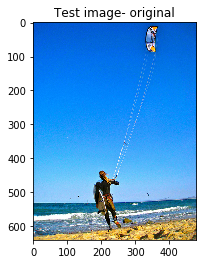

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


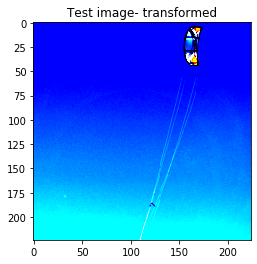

Predicted caption: 

a man standing on a ladder next to a fire hydrant .
a man standing on the side of a street .


Original captions labelled by human annotators: 

A man is standing on the beach with a surfboard, flying a kite.
A woman flying a kite over a sandy beach.
a para sailor launching his sail at the beach.


In [2]:
from src.model_utils import predict_from_COCO
%matplotlib inline

image_folder_path = './data/images/'

'''
By default, the function retrieves the most recently trained model
'''
predict_from_COCO(image_folder_path = image_folder_path, vocab_path = vocab_path, model_path = model_path,\
                       training_image_ids_path = training_image_ids_path)
'''
To run with downloaded model weights, update the model_folder variable with the download path (see example below).
'''
# model_folder = './Gender_Neutral_Captioning_model/'
# vocab_path = model_folder + 'vocab.pkl'
# model_path = model_folder + 'best-model.pkl'
# training_image_ids_path = model_folder + 'training_image_ids.pkl'
# predict_from_COCO(image_folder_path = image_folder_path, vocab_path = vocab_path, model_path = model_path,\
#                        training_image_ids_path = training_image_ids_path)

### b. Predict on any images 

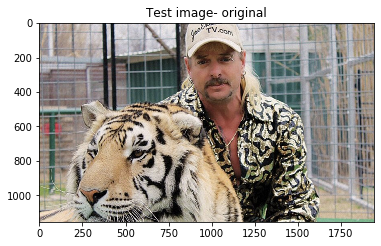

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


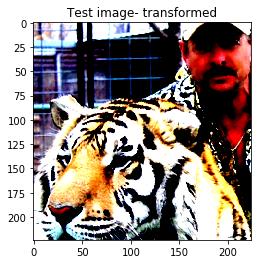

Predicted caption: 

a man is riding a horse in a rodeo .


In [1]:
from src.model_utils import predict_from_image
%matplotlib inline

image_path = './data/test_image.png'
'''
By default, the function retrieves the most recently trained model
'''
# predict_from_image(image_path = image_path)
'''
To run with downloaded model weights, update the model_folder variable with the download path (see example below).
'''
model_folder = './Gender_Neutral_Captioning_model/'
vocab_path = model_folder + 'vocab.pkl'
model_path = model_folder + 'best-model.pkl'
training_image_ids_path = model_folder + 'training_image_ids.pkl'
predict_from_image(image_path = image_path, vocab_path = vocab_path, model_path = model_path)

## Part IV. Evaluate Model Performance

You can use the function **eval_model** in src.eval_utils to extract a test set from COCO to 
As the original COCO dataset is skewed, to better understand model's accuracy performance for different classes ("female", "male", "neutral"), you can experiment with the following modes.

- random: model performance estimates may be overly optimistic, as the COCO dataset has more male images, therefore the class classification errors are unbalanced.
- balanced_mode: balanced between male, female and neutral gender nouns, using estimated Ground Truth labels
- balanced_clean: balanced between male, female and neutral gender nouns, only using images when all captions agree on the same gender noun

In [2]:
from src.eval_utils import eval_model

image_folder_path = './data/images/'
sample_size = 50

'''
By default, the function retrieves the most recently trained model
'''
# confusion_matrix, accuracy_score, bleu = eval_model(image_folder_path = image_folder_path,\
#                                                     sample_size = sample_size, mode = 'balanced_mode')

'''
To run with downloaded model weights, update the model_folder variable with the download path (see example below).
'''
model_folder = './Gender_Neutral_Captioning_model/'
vocab_path = model_folder + 'vocab.pkl'
model_path = model_folder + 'best-model.pkl'
training_image_ids_path = model_folder + 'training_image_ids.pkl'

confusion_matrix_df, accuracy, bleu = eval_model(image_folder_path = image_folder_path, vocab_path = vocab_path,\
                                                 model_path = model_path, \
                                                 training_image_ids_path = training_image_ids_path,\
                                                 sample_size = sample_size, mode = 'balanced_mode')

[nltk_data] Downloading package punkt to /Users/kuly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kuly/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Confusion Matrix (columns = Ground Truth gender, rows = Predicted gender):
         male  neutral  female
male        8        4       5
neutral     4        5       7
female      5        3       9

Accuracy score: 0.44

Test Bleu Score (compared against original human labels of test set):0.9271596670239559
